In [1]:
# Importing required libraries
import nltk

import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading the dataset
data = pd.read_csv("https://raw.githubusercontent.com/nsrozak/Python_AlexaSentimentAnalysis/master/amazon_alexa.tsv",sep='\t')
# Creating a new column sentiment based on overall ratings
def sentiments(df):
  if df['rating'] > 3.0:
    return 'Positive'
  elif df['rating'] <= 3.0:
    return 'Negative'
data['sentiment'] = data.apply(sentiments, axis=1)

In [3]:
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [4]:
#Check if there are any null values
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()

verified_reviews    0
sentiment           0
dtype: int64

In [5]:
def cleaning(df, stop_words):
    
    #converting to lowercase
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 

            ' '.join(x.lower() for x in x.split()))


    # Replacing the digits/numbers

    df['verified_reviews'] = df['verified_reviews'].str.replace('d', ''

            )

    # Removing stop words

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 

            ' '.join(x for x in x.split() if x not in stop_words))

    # Lemmatization

    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: 

            ' '.join([Word(x).lemmatize() for x in x.split()]))

    return df

stop_words = stopwords.words('english')

data_v1 = cleaning(data_v1, stop_words)

In [6]:
data_v1.head()

,verified_reviews,sentiment
0,love echo!,Positive
1,love it!,Positive
2,"sometimes playing game, answer question correc...",Positive
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",Positive
4,music,Positive


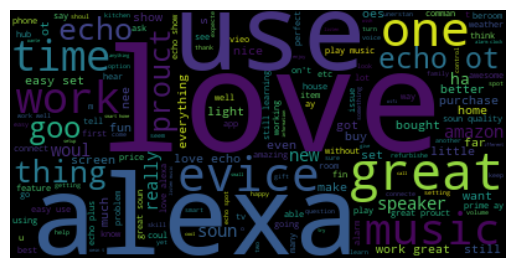

In [7]:
common_words=''
for i in data_v1.verified_reviews:
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [8]:
# Encoded the target column
lb=LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])

In [9]:
data_v1.head(10)

,verified_reviews,sentiment
0,love echo!,1
1,love it!,1
2,"sometimes playing game, answer question correc...",1
3,"ha lot fun thing. 4 yr ol learns inosaurs, con...",1
4,music,1
5,receive echo gift. neee another bluetooth some...,1
6,"without cellphone, cannot use many features. i...",0
7,think 5th one i've purchase. i'm working getti...,1
8,look great,1
9,love it! i’ve listene song haven’t hear since ...,1


In [10]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
X = pad_sequences(X)#helps convert all the inouts to the same length
X

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0,   0,   5],
       [  0,   0,   0, ..., 263, 276,  24],
       ...,
       [  0,   0,   0, ...,  89, 326,  32],
       [  0,   0,   0, ..., 217,  58, 290],
       [  0,   0,   0, ...,   0,   0,   0]])

In [11]:
model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2)) # 176 is the number of features in the output
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 319, 120)          60000     
                                                                 
 spatial_dropout1d (Spatial  (None, 319, 120)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269442 (1.03 MB)
Trainable params: 269442 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [12]:
#Splitting the data into training and testing
y=pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [13]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [14]:
batch_size=32
model.fit(X_train, y_train, epochs =20,batch_size=batch_size, verbose = 1)

Epoch 1/20
69/69 [==============================] - 54s 767ms/step - loss: 0.4030 - accuracy: 0.8689
Epoch 2/20
69/69 [==============================] - 62s 900ms/step - loss: 0.3022 - accuracy: 0.8816
Epoch 3/20
69/69 [==============================] - 70s 1s/step - loss: 0.2383 - accuracy: 0.9043
Epoch 4/20
69/69 [==============================] - 78s 1s/step - loss: 0.1995 - accuracy: 0.9256
Epoch 5/20
69/69 [==============================] - 79s 1s/step - loss: 0.1883 - accuracy: 0.9265
Epoch 6/20
69/69 [==============================] - 79s 1s/step - loss: 0.1738 - accuracy: 0.9315
Epoch 7/20
69/69 [==============================] - 79s 1s/step - loss: 0.1673 - accuracy: 0.9365
Epoch 8/20
69/69 [==============================] - 79s 1s/step - loss: 0.1492 - accuracy: 0.9438
Epoch 9/20
69/69 [==============================] - 81s 1s/step - loss: 0.1346 - accuracy: 0.9474
Epoch 10/20
69/69 [==============================] - 82s 1s/step - loss: 0.1285 - accuracy: 0.9510
Epoch 11/20
6

In [15]:
model.evaluate(X_test,y_test)

30/30 [==============================] - 5s 156ms/step - loss: 0.4321 - accuracy: 0.9101


[0.432096928358078, 0.9100528955459595]

In [16]:
model.save('alexa.keras')